## Check Done

In [1]:
pwd

'd:\\research\\fedmiss_bench\\results'

In [2]:
import os
import itertools
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [127]:
nnn_imp_fed = {
    'simple': ['local', 'fedavg'],
    'em': ['local', 'fedavg'],
    'linear_ice': ['local', 'fedavg'],
    'missforest': ['local', 'fedtree']
}

nn_imp_fed = {
    'miwae': ['local', 'fedavg', 'fedavg_ft', 'fedprox'],
    'gain': ['local', 'fedavg', 'fedavg_ft', 'fedprox'],
}

dataset_dp = {
    'codrna': ['iid-even', 'iid-uneven', 'niid-f1', 'niid-f2'],
    'california': ['iid-even', 'iid-uneven', 'niid-t1', 'niid-t2'],
    'hhip': ['iid-even', 'iid-uneven', 'niid-t1', 'niid-t2'],
    'dvisits': ['iid-even', 'iid-uneven', 'niid-t1', 'niid-t2'],
    'vehicle': ['iid-even', 'iid-uneven', 'niid-f1', 'niid-f2'],
    'school_pca': ['iid-even', 'iid-uneven', 'niid-f1', 'niid-f2'],
}

dataset_metric_pred = {
    'codrna': ['accuracy', 'f1', 'auc', 'prc'],
    'california': ['mse', 'mae', 'r2', 'msle'],
    'hhip': ['mse', 'mae', 'r2', 'msle'],
    'dvisits': ['mse', 'mae', 'r2', 'msle'],
    'vehicle': ['accuracy', 'f1', 'auc', 'prc'],
    'school_pca': ['mse', 'mae', 'r2', 'msle'],
}

In [128]:
def load_ret(datasets, imputers, met):
    
    rets = []
    unfinished = {}
    for dataset in datasets:
        
        data_partition = dataset_dp[dataset]
        unfinished[dataset] = {}
        missing = ['mcar', 'mar-homog', 'mnar2-homog', 'mar-heter', 'mnar2-heter']
        models = ['nn']
        
        for imputer in imputers:
            unfinished[dataset][imputer] = set()
            print(dataset, imputer)            
            if imputer in nnn_imp_fed:
                rounds = [0,1,2,3,4,5,6,7,8,9]
                feds = nnn_imp_fed[imputer]
            else:
                rounds = [0,1,2,3,4]
                feds = nn_imp_fed[imputer]

            param = itertools.product(feds, data_partition, missing, rounds, models)
            dir_path = f'./raw_results/eval_results/alpha/{dataset}/'

            count = 0
            for i, (fed, dp, ms, round, model) in enumerate(param):
                
                file_path = f'{dir_path}{dp}_{ms}/{imputer}/{fed}/{round}/{model}/eval_results.json'
            
                try:
                    with open(file_path, 'r') as f:
                        ret = json.load(f)
                        if met == 'imp':
                            metrics = ['rmse', 'sliced-ws']
                            ret_metrics = [ret['results']['imp_quality'][metric] for metric in metrics]
                        elif met == 'pred':
                            metrics = dataset_metric_pred[dataset]
                            ret_metrics = [ret['results']['pred_performance'][metric] for metric in metrics]
                        else:
                            raise ValueError('Invalid metric')
                        
                        for id, items in enumerate(zip(*ret_metrics)):
                            setting = {
                                'dataset': dataset,
                                'data_partition': dp,
                                'imputer': imputer,
                                'fed': fed,
                                'missing': ms,
                                'round': round,
                                'model': model,
                                'client_id': id
                            }
                            setting.update({metric: item for metric, item in zip(metrics, items)})
                            rets.append(setting)
                
                except Exception as e:
                    count += 1
                    unfinished[dataset][imputer].add((dataset, dp, ms, imputer, fed, round, model, e))
                    continue

            print(count)
        
    return rets, unfinished
            

In [70]:
result_pred, unfinished = load_ret(
    ['codrna', 'california', 'dvisits', 'vehicle', 'hhip', 'school_pca'],
    ['simple', 'em', 'linear_ice', 'missforest', 'miwae', 'gain'], 
    met = 'pred'
)

codrna simple
0
codrna em
0
codrna linear_ice
0
codrna missforest
0
codrna miwae
0
codrna gain
0
california simple
0
california em
0
california linear_ice
0
california missforest
0
california miwae
0
california gain
0
dvisits simple
0
dvisits em
0
dvisits linear_ice
0
dvisits missforest
0
dvisits miwae
0
dvisits gain
0
vehicle simple
0
vehicle em
0
vehicle linear_ice
0
vehicle missforest
0
vehicle miwae
0
vehicle gain
0
hhip simple
0
hhip em
0
hhip linear_ice
0
hhip missforest
0
hhip miwae
0
hhip gain
0
school_pca simple
0
school_pca em
0
school_pca linear_ice
0
school_pca missforest
0
school_pca miwae
0
school_pca gain
0


In [9]:
df_records = []
for item in unfinished['hhip']['miwae']:
    record = {
        'dataset': item[0],
        'data_partition': item[1],
        'missing': item[2],
        'imputer': item[3],
        'fed': item[4],
        'round': item[5]
    }
    df_records.append(record)
    # print(f"python run_evaluation.py dataset_name={item[0]} data_partition_name={item[1]} missing_scenario_name={item[2]} "
    #       f"imputer_name={item[3]} fed_strategy_name={item[4]} round_idx={item[5]} eval_params.model=nn experiment_name=fed_imp_pc2")
if len(df_records) > 0:
    df_records = pd.DataFrame(df_records)
    df_records['data_partition'] = pd.Categorical(df_records['data_partition'], categories=['iid-even', 'iid-uneven', 'niid-t1', 'niid-t2'], ordered=True)
    df_records['missing'] = pd.Categorical(df_records['missing'], categories=['mcar', 'mar-homog', 'mnar2-homog', 'mar-heter', 'mnar2-heter'], ordered=True)
    df_records['imputer'] = pd.Categorical(df_records['imputer'], categories=['simple', 'em', 'linear_ice', 'missforest', 'miwae', 'gain'], ordered=True)
    df_records['fed'] = pd.Categorical(df_records['fed'], categories=['local', 'fedavg', 'fedavg_ft', 'fedprox'], ordered=True)
    df_records['round'] = pd.Categorical(df_records['round'], categories=[0,1,2,3,4], ordered=True)
    df_records = df_records.sort_values(['dataset', 'data_partition', 'missing', 'imputer', 'fed', 'round'])
    df_records = df_records.groupby(['dataset', 'data_partition', 'missing', 'imputer', 'fed'], observed = True)['round'].agg(list).reset_index()

    for row in df_records.iterrows():
        item = row[1].values
        print(f"python run_evaluation.py dataset_name={item[0]} data_partition_name={item[1]} missing_scenario_name={item[2]} "
            f"imputer_name={item[3]} fed_strategy_name={item[4]} round_idx={','.join([str(i)  for i in item[5]])} eval_params.model=nn experiment_name=fed_imp_pc2")

In [10]:
result_imp, unfinished = load_ret(
    #['codrna', 'california', 'dvisits', 'vehicle', 'hhip', 'school_pca'], 
    ['codrna', 'california', 'dvisits', 'hhip', 'vehicle', 'school_pca'],
    ['simple', 'em', 'linear_ice', 'missforest', 'miwae', 'gain'], 
    met = 'imp'
)

codrna simple
0
codrna em
0
codrna linear_ice
0
codrna missforest
0
codrna miwae
0
codrna gain
0
california simple
0
california em
0
california linear_ice
0
california missforest
0
california miwae
0
california gain
0
dvisits simple
0
dvisits em
0
dvisits linear_ice
0
dvisits missforest
0
dvisits miwae
0
dvisits gain
0
hhip simple
0
hhip em
0
hhip linear_ice
0
hhip missforest
0
hhip miwae
0
hhip gain
0
vehicle simple
0
vehicle em
0
vehicle linear_ice
0
vehicle missforest
0
vehicle miwae
0
vehicle gain
0
school_pca simple
0
school_pca em
0
school_pca linear_ice
0
school_pca missforest
0
school_pca miwae
0
school_pca gain
0


In [14]:
df_imp = pd.DataFrame(result_imp)
df_imp = df_imp[df_imp['model'] == 'nn']
df_imp = df_imp.drop(columns=['model'])
df_imp.replace({'niid-f1': 'niid1', 'niid-f2': 'niid2', 'niid-t1': 'niid1', 'niid-t2': 'niid2'}, inplace=True)
df_imp = df_imp[df_imp['client_id'] != 10].reset_index(drop=True)
df_imp = df_imp.replace({'fedtree': 'fedavg'})
df_imp.columns = ['dataset', 'partition', 'imp', 'fed', 'missing', 'round_id', 'client_id', 'rmse', 'sliced-ws']

df_imp_agg = df_imp.groupby(['dataset', 'partition', 'missing', 'imp', 'fed', 'round_id'], observed = False).agg(
        {'rmse': 'mean', 'sliced-ws': 'mean'}).reset_index()
df_imp_agg_mean = df_imp_agg.groupby(['dataset', 'partition', 'missing', 'imp', 'fed'], observed = False).agg(
        {'rmse': 'mean', 'sliced-ws': 'mean'}).reset_index()
df_imp_agg_mean = df_imp_agg_mean[df_imp_agg_mean['fed'] == 'fedavg']
df_imp_agg_mean['dataset'] = pd.Categorical(
    df_imp_agg_mean['dataset'], categories = ['codrna', 'california', 'dvisits', 'hhip', 'vehicle', 'school_pca'], ordered = True
)

df_imp_agg_mean['missing'] = pd.Categorical(
    df_imp_agg_mean['missing'], categories = ['mcar', 'mar-homog', 'mar-heter', 'mnar2-homog', 'mnar2-heter'], ordered = True
)

ret = df_imp_agg_mean
ret['imp'] = pd.Categorical(ret['imp'], categories = ['simple', 'em', 'linear_ice', 'missforest', 'miwae', 'gain'], ordered = True)
ret = ret.drop(['fed'], axis = 1)
ret['rmse'] = ret['rmse']*10
ret['sliced-ws'] = ret['sliced-ws']*10

pivot_df = ret.pivot_table(
    index=['dataset', 'imp'],
    columns=['missing', 'partition'],
    values='sliced-ws',
    aggfunc='mean'
)

pivot_df.sort_index(level=['dataset', 'imp'], inplace=True)
pivot_df.to_excel('./imp_ws.xlsx')

D:\TMP\ipykernel_108756\1606333376.py:28: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = ret.pivot_table(


In [22]:
df_imp = pd.DataFrame(result_imp)
df_imp = df_imp[df_imp['model'] == 'nn']
df_imp = df_imp.drop(columns=['model'])
df_imp.replace({'niid-f1': 'niid1', 'niid-f2': 'niid2', 'niid-t1': 'niid1', 'niid-t2': 'niid2'}, inplace=True)
df_imp = df_imp[df_imp['client_id'] != 10].reset_index(drop=True)
df_imp = df_imp.replace({'fedtree': 'fedavg'})
df_imp.columns = ['dataset', 'partition', 'imp', 'fed', 'missing', 'round_id', 'client_id', 'rmse', 'sliced-ws']

df_imp_agg = df_imp.groupby(['dataset', 'partition', 'missing', 'imp', 'fed', 'round_id'], observed = False).agg(
        {'rmse': 'mean', 'sliced-ws': 'mean'}).reset_index()
df_imp_agg_mean = df_imp_agg.groupby(['dataset', 'partition', 'missing', 'imp', 'fed'], observed = False).agg(
        {'rmse': 'mean', 'sliced-ws': 'mean'}).reset_index()
df_imp_agg_mean = df_imp_agg_mean[
    (df_imp_agg_mean['imp'] == 'gain') & (df_imp_agg_mean['fed'].isin(['fedavg','fedprox', 'fedavg_ft']))
]

df_imp_agg_mean['fed'] = pd.Categorical(
    df_imp_agg_mean['fed'], categories = ['fedavg', 'fedprox', 'fedavg_ft'], ordered = True
)

df_imp_agg_mean['dataset'] = pd.Categorical(
    df_imp_agg_mean['dataset'], categories = ['codrna', 'california', 'dvisits', 'hhip', 'vehicle', 'school_pca'], ordered = True
)

df_imp_agg_mean['missing'] = pd.Categorical(
    df_imp_agg_mean['missing'], categories = ['mcar', 'mar-homog', 'mar-heter', 'mnar2-homog', 'mnar2-heter'], ordered = True
)

ret = df_imp_agg_mean
ret = ret.drop(['imp'], axis = 1)
ret['rmse'] = ret['rmse']*10
ret['sliced-ws'] = ret['sliced-ws']*10
pivot_df = ret.pivot_table(
    index=['dataset', 'fed'],
    columns=['missing', 'partition'],
    values='rmse',
    aggfunc='mean'
)

pivot_df.sort_index(level=['dataset', 'fed'], inplace=True)
pivot_df.to_excel('./imp_rmse_gain.xlsx')

D:\TMP\ipykernel_108756\3903289940.py:33: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = ret.pivot_table(


In [79]:
df_pred = pd.DataFrame(result_pred)
df_pred = df_pred[df_pred['model'] == 'nn']
df_pred = df_pred.drop(columns=['model'])
df_pred.replace({'niid-f1': 'niid1', 'niid-f2': 'niid2', 'niid-t1': 'niid1', 'niid-t2': 'niid2'}, inplace=True)
df_pred = df_pred[df_pred['client_id'] != 10].reset_index(drop=True)
df_pred = df_pred.replace({'fedtree': 'fedavg'})

dataset_metric = {
    'codrna': 'f1',
    'california': 'mae',
    'hhip': 'mae',
    'dvisits': 'mae',
    'vehicle': 'accuracy',
    'school_pca': 'mae',
}

dataset_task = {
    'codrna': 'clf',
    'california': 'reg',
    'hhip': 'reg',
    'dvisits': 'reg',
    'vehicle': 'clf',
    'school_pca': 'reg',
}

#df_pred['mse'] = df_pred['mse'].apply(np.sqrt)
df_pred['pred'] = df_pred.apply(lambda x: x[dataset_metric[x['dataset']]], axis=1)
df_pred = df_pred.drop(['accuracy', 'f1', 'auc', 'prc', 'mse', 'mae', 'r2', 'msle'], axis=1)
#df_pred = df_pred.drop(['accuracy', 'f1', 'auc', 'prc'], axis=1)
df_pred['task_type'] = df_pred['dataset'].map(dataset_task)
df_pred.columns = ['dataset', 'partition', 'imp', 'fed', 'missing', 'round_id', 'client_id', 'pred', 'task_type']

In [27]:
df_pred_agg = df_pred.groupby(['dataset', 'partition', 'missing', 'imp', 'fed', 'round_id'], observed = False).agg(
        {'pred': 'mean'}).reset_index()
df_pred_agg_mean = df_pred_agg.groupby(['dataset', 'partition', 'missing', 'imp', 'fed'], observed = False).agg(
        {'pred': 'mean'}).reset_index()
df_pred_agg_mean = df_pred_agg_mean[
    (df_pred_agg_mean['imp'] == 'miwae') & (df_pred_agg_mean['fed'].isin(['fedavg','fedprox', 'fedavg_ft']))
]

df_pred_agg_mean['dataset'] = pd.Categorical(
    df_pred_agg_mean['dataset'], categories = ['codrna', 'california', 'dvisits', 'hhip', 'vehicle', 'school_pca'], ordered = True
)

df_pred_agg_mean['missing'] = pd.Categorical(
    df_pred_agg_mean['missing'], categories = ['mcar', 'mar-homog', 'mar-heter', 'mnar2-homog', 'mnar2-heter'], ordered = True
)

df_pred_agg_mean['fed'] = pd.Categorical(
    df_pred_agg_mean['fed'], categories = ['fedavg', 'fedprox', 'fedavg_ft'], ordered = True
)

ret = df_pred_agg_mean
pivot_df = ret.pivot_table(
    index=['dataset', 'fed'],
    columns=['missing', 'partition'],
    values='pred',
    aggfunc='mean'
)

pivot_df.sort_index(level=['dataset', 'fed'], inplace=True)
pivot_df.to_excel('./imp_pred_miwae.xlsx')

D:\TMP\ipykernel_108756\4206202310.py:22: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = ret.pivot_table(


In [ ]:
df_pred_agg = df_pred.groupby(['dataset', 'partition', 'missing', 'imp', 'fed', 'round_id'], observed = False).agg(
        {'pred': 'mean'}).reset_index()
df_pred_agg_mean = df_pred_agg.groupby(['dataset', 'partition', 'missing', 'imp', 'fed'], observed = False).agg(
        {'pred': 'mean'}).reset_index()
df_pred_agg_mean = df_pred_agg_mean[df_pred_agg_mean['fed'] == 'fedavg']
df_pred_agg_mean['dataset'] = pd.Categorical(
    df_pred_agg_mean['dataset'], categories = ['codrna', 'california', 'dvisits', 'hhip', 'vehicle', 'school_pca'], ordered = True
)

df_pred_agg_mean['missing'] = pd.Categorical(
    df_pred_agg_mean['missing'], categories = ['mcar', 'mar-homog', 'mar-heter', 'mnar2-homog', 'mnar2-heter'], ordered = True
)

ret = df_pred_agg_mean
ret['imp'] = pd.Categorical(ret['imp'], categories = ['simple', 'em', 'linear_ice', 'missforest', 'miwae', 'gain'], ordered = True)
ret = ret.drop(['fed'], axis = 1)
pivot_df = ret.pivot_table(
    index=['dataset', 'imp'],
    columns=['missing', 'partition'],
    values='pred',
    aggfunc='mean'
)

pivot_df.sort_index(level=['dataset', 'imp'], inplace=True)
pivot_df.to_excel('./imp_pred.xlsx')

In [80]:
df_pred

,dataset,partition,imp,fed,missing,round_id,client_id,pred,task_type
0,codrna,iid-even,simple,local,mcar,0,0,0.910569,clf
1,codrna,iid-even,simple,local,mcar,0,1,0.869565,clf
2,codrna,iid-even,simple,local,mcar,0,2,0.885246,clf
3,codrna,iid-even,simple,local,mcar,0,3,0.854839,clf
4,codrna,iid-even,simple,local,mcar,0,4,0.888889,clf
...,...,...,...,...,...,...,...,...,...
143995,school_pca,niid2,gain,fedprox,mnar2-heter,4,5,7.757688,reg
143996,school_pca,niid2,gain,fedprox,mnar2-heter,4,6,4.916395,reg
143997,school_pca,niid2,gain,fedprox,mnar2-heter,4,7,7.075554,reg
143998,school_pca,niid2,gain,fedprox,mnar2-heter,4,8,6.249037,reg


## Evaluation Metrics

In [81]:
def agg_client(df, method = 'mean', metric = 'pred'):
    df_agg = df.groupby(['dataset', 'partition', 'missing', 'imp', 'fed', 'client_id'], observed = False).agg(
        {metric: method}).reset_index()
    return df_agg

def agg_client_round(df, method = 'mean', metric = 'pred'):
    df_agg = df.groupby(['dataset', 'partition', 'missing', 'imp', 'fed', 'round_id'], observed = False).agg(
        {metric: method}).reset_index()
    return df_agg

In [97]:
def calculate_improvement(df, metric = 'pred'):
    
    local_baseline = df[df['fed'] == 'local'].copy()
    local_baseline.rename(columns={metric: f'{metric}_local'}, inplace=True)
    keys = ['dataset', 'partition', 'missing', 'imp', 'client_id', 'round_id']
    df = df.merge(local_baseline[keys + [f'{metric}_local']], on=keys, how='left')
    del local_baseline
    
    if metric == 'pred':
    
        df['pred_diff'] = df.apply(
            lambda x: (x['pred'] - x['pred_local']) if x['task_type'] == 'clf' else -(x['pred'] - x['pred_local']), axis=1
        )
        
        # df['pred_improv'] = df.apply(
        #     lambda x: (x['pred_diff'] / (x['pred_local'] + 1e-5)) * 100 if x['task_type'] == 'reg' else x['pred_diff']*100, axis=1
        # )
        df['pred_improv'] = df.apply(
             lambda x: (x['pred_diff'] / (x['pred_local'] + 1e-5)) * 100, axis=1
        )
    else:
        df[f'{metric}_diff'] = df.apply(
            lambda x: -(x[metric] - x[f'{metric}_local']), axis=1
        )
        df[f'{metric}_improv'] = df.apply(
            lambda x: (x[f'{metric}_diff'] / (x[f'{metric}_local'] + 1e-5)) * 100, axis=1
        )
    
    df = df[df['fed'] != 'local']
    #final_df = df[['dataset', 'partition', 'missing', 'imp', 'fed', 'client_id', 'round_id', 'rmse_diff', 'rmse_improv', 'ws_diff', 'ws_improv']]
    
    return df

def agg_client_improv(df, method = 'mean', metric = 'improv', m = 'pred'):
    print(df.columns)
    df['fed'] = df['fed'].astype(str)
    df_agg = df.groupby(['dataset', 'partition', 'missing', 'imp', 'fed', 'client_id'], observed = False).agg(
        {f'{m}_{metric}': method}).reset_index()
    return df_agg

def agg_client_improv2(df, method = 'mean', metric = 'improv', m = 'pred'):
    print(df.columns)
    df['fed'] = df['fed'].astype(str)
    df_agg = df.groupby(['dataset', 'partition', 'missing', 'imp', 'fed', 'round_id'], observed = False).agg(
        {f'{m}_{metric}': method}).reset_index()
    return df_agg

def agg_client_improv_std(df, method = 'std', metric = 'improv', m = 'pred'):
    print(df.columns)
    df['fed'] = df['fed'].astype(str)
    df_agg = df.groupby(['dataset', 'partition', 'missing', 'imp', 'fed', 'round_id'], observed = False).agg(
        {f'{m}_{metric}': method}).reset_index()
    return df_agg

df_pred_improv = calculate_improvement(df_pred)
df_imp_improv = calculate_improvement(df_imp, metric = 'rmse')
df_imp_improv_ws = calculate_improvement(df_imp, metric = 'sliced-ws')

In [84]:
dataset_dp = {
    'codrna': ['iid-even', 'iid-uneven', 'niid-f1', 'niid-f2'],
    'california': ['iid-even', 'iid-uneven', 'niid-t1', 'niid-t2'],
    'hhip': ['iid-even', 'iid-uneven', 'niid-t1', 'niid-t2'],
    'dvisits': ['iid-even', 'iid-uneven', 'niid-t1', 'niid-t2'],
    'vehicle': ['iid-even', 'iid-uneven', 'niid-f1', 'niid-f2'],
    'school_pca': ['iid-even', 'iid-uneven', 'niid-f1', 'niid-f2'],
}

scenario_mapping = {
    'mcar': 'MCAR',
    'mar-homog': 'MAR(HG)',
    'mnar2-homog': 'MNAR(HG)',
    'mnar2-heter': 'MNAR(HT)',
    'mar-heter': 'MAR(HT)',
}

dp_mapping = {
    'iid-even': 'IID1',
    'iid-uneven': 'IID2',
    'niid1': 'NIID1',
    'niid2': 'NIID2',
}

dataset_mapping = {
    'codrna': 'CRNA',
    'california': 'HOUSE',
    'dvisits': 'DVIS',
    'hhip': 'HHNP',
    'vehicle': 'VHCL',
    'school_pca': 'SCHL',
}

method_mapping = {
    'simple': 'Simple',
    'em': 'EM',
    'linear_ice': 'Linear-ICE',
    'missforest': 'MissForest',
    'miwae': 'MIWAE',
    'gain': 'GAIN',
}

dataset_metric_mapping = {
    'codrna': 'F1',
    'california': 'MAE',
    'hhip': 'MAE',
    'dvisits': 'MAE',
    'vehicle': 'ACCU',
    'school_pca': 'MAE',
}

## Improvement Barchart

In [85]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
import seaborn as sns

In [87]:
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'figure.dpi': '600'})

bin_width = 1.0
interval_width = 1.2
lw = 1
fontsize = 20
edgecolor = 'black'

def make_bold(s):
    return r'\textbf{' + s + '}'

def make_label(s, m):
    return r'\textbf{' + s + '}\n' + r'(' + m + ')'

def bar_plot_pred_improv(df_improv, metric, method, scenarios, datasets, fed = 'fedavg', filename = None):
    
    
    fig, axes = plt.subplots(len(datasets), len(scenarios), figsize=(20, 2*len(datasets)), squeeze=False, sharey='row', sharex=True)

    for row_idx, dataset in enumerate(datasets):
        
        partitions = ['iid-even', 'iid-uneven', 'niid1', 'niid2']
        result_avg = df_improv[df_improv['dataset'] == dataset]
        result_avg['imp'] = pd.Categorical(result_avg['imp'], categories=method, ordered=True)
        result_avg[metric] = result_avg[metric]
        
        for col_idx, scenario in enumerate(scenarios):
                
            filtered_df = result_avg[
                (result_avg['missing'] == scenario) & (result_avg['partition'].isin(partitions)) & (result_avg['fed'] == fed)
            ]
            
            # plot bars for each partition
            for i in range(len(partitions)):
                partition = partitions[i]
                bar_heights = []
                bar_errors = []
                for j in range(len(method)):
                    d = filtered_df[(filtered_df['imp'] == method[j]) & (filtered_df['partition'] == partition)][metric].values
                    bar_heights.append(d.mean())
                    bar_errors.append(d.std())
                    
                bar_positions = [i*interval_width + i*len(method)*bin_width + j*bin_width for j in range(len(method))]
                bp = axes[row_idx, col_idx].bar(
                    x = bar_positions, height = bar_heights, width = bin_width, linewidth=[lw]*len(method),
                    ecolor=edgecolor, edgecolor = edgecolor, color = colormaps['Paired'].colors[:len(method)], yerr = bar_errors,
                    error_kw = dict(lw=0.7, capsize=0.7, capthick=0.7)
                    #hatch = [None, None, None, None,  'x', 'x']
                    #color = ['#1e81b0', '#abdbe3', '#7f7f7f', '#d62728'], #hatch = ['\\', 'x', '-',  '/']
                )
            
            # bar labels
            n_groups = len(partitions)
            n_bars = len(method)
            x0 = 0 - bin_width/2 - interval_width
            x1 = (n_groups-1)*interval_width + (n_groups-1)*n_bars*bin_width + (n_bars-1)*bin_width + bin_width/2 + interval_width
            axes[row_idx, col_idx].set_xlim([x0, x1])
            axes[row_idx, col_idx].set_xticks([i*interval_width + i*n_bars*bin_width + 1.5*bin_width for i in range(n_groups)])
            axes[row_idx, col_idx].set_xticklabels([make_bold(dp_mapping[item]) for item in partitions], fontsize=fontsize, rotation=45) 
            axes[0, col_idx].set_title(make_bold(scenario_mapping[scenario]), fontsize=fontsize)
            axes[row_idx, col_idx].set_xlabel('')
            axes[row_idx, 0].set_ylabel(make_label(dataset_mapping[dataset], dataset_metric_mapping[dataset]), fontsize=fontsize)
            axes[row_idx, col_idx].tick_params(axis='y', which='major', labelsize=fontsize - 2)
            axes[row_idx, col_idx].avlines = axes[row_idx, col_idx].axhline(y=0, color='black', linewidth=1)
            axes[row_idx, col_idx].spines['bottom'].set_color('grey')
            axes[row_idx, col_idx].spines['top'].set_color('grey')
            axes[row_idx, col_idx].spines['left'].set_color('grey')
            axes[row_idx, col_idx].spines['right'].set_color('grey')

    legend = plt.legend(
        [bp[i] for i in range(len(method))], 
        [make_bold(method_mapping[m]) for m in method], 
        loc='lower center', bbox_to_anchor=(-1.5, -0.90), 
        ncol=6, fontsize = fontsize, frameon=False
    )
    
    for text in legend.get_texts():
        text.set_fontsize(fontsize-1)
        text.set_fontweight('bold')
    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    
    plt.savefig(f"./figures/{filename}", dpi = 600, bbox_inches='tight')
    plt.show()

method = ['simple', 'em', 'linear_ice', 'missforest', 'miwae', 'gain']
scenarios = ['mcar', 'mar-homog', 'mnar2-homog', 'mar-heter', 'mnar2-heter']

df_improv_agg = agg_client_improv2(df_pred_improv, method = 'median', metric = 'improv')
df_improv_agg['fed'] = df_improv_agg['fed'].astype(str)

bar_plot_imp_improv(
    df_improv_agg, 'pred_improv', method, scenarios, ['codrna', 'california', 'dvisits', 'hhip', 'vehicle', 'school_pca'], 
    fed = 'fedavg', filename = 'pred_improv_err.png'
)

Index(['dataset', 'partition', 'imp', 'fed', 'missing', 'round_id',
       'client_id', 'pred', 'task_type', 'pred_local', 'pred_diff',
       'pred_improv'],
      dtype='object')


In [99]:
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'figure.dpi': '600'})

bin_width = 1.0
interval_width = 1.2
lw = 1
fontsize = 20
edgecolor = 'black'

def make_bold(s):
    return r'\textbf{' + s + '}'

def make_label(s, m):
    if m == '':
        return r'\textbf{' + s + '}'
    else:
        return r'\textbf{' + s + '}\n' + r'(' + m + ')'

def bar_plot_imp_improv(df_improv, metric, method, scenarios, datasets, fed = 'fedavg', filename = None):
    
    
    fig, axes = plt.subplots(len(datasets), len(scenarios), figsize=(20, 2*len(datasets)), squeeze=False, sharey='row', sharex=True)

    for row_idx, dataset in enumerate(datasets):
        
        partitions = ['iid-even', 'iid-uneven', 'niid1', 'niid2']
        result_avg = df_improv[df_improv['dataset'] == dataset]
        result_avg['imp'] = pd.Categorical(result_avg['imp'], categories=method, ordered=True)
        result_avg[metric] = result_avg[metric]
        
        for col_idx, scenario in enumerate(scenarios):
                
            filtered_df = result_avg[
                (result_avg['missing'] == scenario) & (result_avg['partition'].isin(partitions)) & (result_avg['fed'] == fed)
            ]
            
            # plot bars for each partition
            for i in range(len(partitions)):
                partition = partitions[i]
                bar_heights = []
                bar_errors = []
                for j in range(len(method)):
                    d = filtered_df[(filtered_df['imp'] == method[j]) & (filtered_df['partition'] == partition)][metric].values
                    bar_heights.append(d.mean())
                    bar_errors.append(d.std())
                    
                bar_positions = [i*interval_width + i*len(method)*bin_width + j*bin_width for j in range(len(method))]
                bp = axes[row_idx, col_idx].bar(
                    x = bar_positions, height = bar_heights, width = bin_width, linewidth=[lw]*len(method),
                    ecolor=edgecolor, edgecolor = edgecolor, color = colormaps['Paired'].colors[:len(method)], yerr = bar_errors,
                    error_kw = dict(lw=0.7, capsize=0.7, capthick=0.7)
                    #hatch = [None, None, None, None,  'x', 'x']
                    #color = ['#1e81b0', '#abdbe3', '#7f7f7f', '#d62728'], #hatch = ['\\', 'x', '-',  '/']
                )
            
            # bar labels
            n_groups = len(partitions)
            n_bars = len(method)
            x0 = 0 - bin_width/2 - interval_width
            x1 = (n_groups-1)*interval_width + (n_groups-1)*n_bars*bin_width + (n_bars-1)*bin_width + bin_width/2 + interval_width
            axes[row_idx, col_idx].set_xlim([x0, x1])
            axes[row_idx, col_idx].set_xticks([i*interval_width + i*n_bars*bin_width + 1.5*bin_width for i in range(n_groups)])
            axes[row_idx, col_idx].set_xticklabels([make_bold(dp_mapping[item]) for item in partitions], fontsize=fontsize, rotation=45) 
            axes[0, col_idx].set_title(make_bold(scenario_mapping[scenario]), fontsize=fontsize)
            axes[row_idx, col_idx].set_xlabel('')
            axes[row_idx, 0].set_ylabel(make_label(dataset_mapping[dataset],''), fontsize=fontsize)
            axes[row_idx, col_idx].tick_params(axis='y', which='major', labelsize=fontsize - 2)
            axes[row_idx, col_idx].avlines = axes[row_idx, col_idx].axhline(y=0, color='black', linewidth=1)
            axes[row_idx, col_idx].spines['bottom'].set_color('grey')
            axes[row_idx, col_idx].spines['top'].set_color('grey')
            axes[row_idx, col_idx].spines['left'].set_color('grey')
            axes[row_idx, col_idx].spines['right'].set_color('grey')

    legend = plt.legend(
        [bp[i] for i in range(len(method))], 
        [make_bold(method_mapping[m]) for m in method], 
        loc='lower center', bbox_to_anchor=(-1.5, -0.94), 
        ncol=6, fontsize = fontsize, frameon=False
    )
    
    for text in legend.get_texts():
        text.set_fontsize(fontsize-1)
        text.set_fontweight('bold')
    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    
    plt.savefig(f"./figures/{filename}", dpi = 600, bbox_inches='tight')
    plt.show()

method = ['simple', 'em', 'linear_ice', 'missforest', 'miwae', 'gain']
scenarios = ['mcar', 'mar-homog', 'mnar2-homog', 'mar-heter', 'mnar2-heter']

df_improv_agg = agg_client_improv2(df_imp_improv_ws, method = 'mean', metric = 'improv', m = 'sliced-ws')
df_improv_agg['fed'] = df_improv_agg['fed'].astype(str)

bar_plot_imp_improv(
    df_improv_agg, 'sliced-ws_improv', method, scenarios, ['codrna', 'california', 'dvisits', 'hhip', 'vehicle', 'school_pca'], 
    fed = 'fedavg', filename = 'ws_improv_err.png'
)

Index(['dataset', 'partition', 'imp', 'fed', 'missing', 'round_id',
       'client_id', 'rmse', 'sliced-ws', 'sliced-ws_local', 'sliced-ws_diff',
       'sliced-ws_improv'],
      dtype='object')


## Comparison between Federated Strategies for MIWAE and GAIN

1. improvement in RMSE and WD => using barchat
2. RMSE and WD => using boxplot

In [100]:
method_fed_mapping = {
    ('miwae', 'fedavg'): 'MIWAE(FedAvg)',
    ('miwae','fedprox'): 'MIWAE(FedProx)',
    ('miwae', 'fedavg_ft'): 'MIWAE(FedAvg-FT)',
    ('gain', 'fedavg'): 'GAIN(FedAvg)',
    ('gain','fedprox'): 'GAIN(FedProx)',
    ('gain', 'fedavg_ft'): 'GAIN(FedAvg-FT)'
}

Index(['dataset', 'partition', 'imp', 'fed', 'missing', 'round_id',
       'client_id', 'rmse', 'sliced-ws', 'rmse_local', 'rmse_diff',
       'rmse_improv'],
      dtype='object')


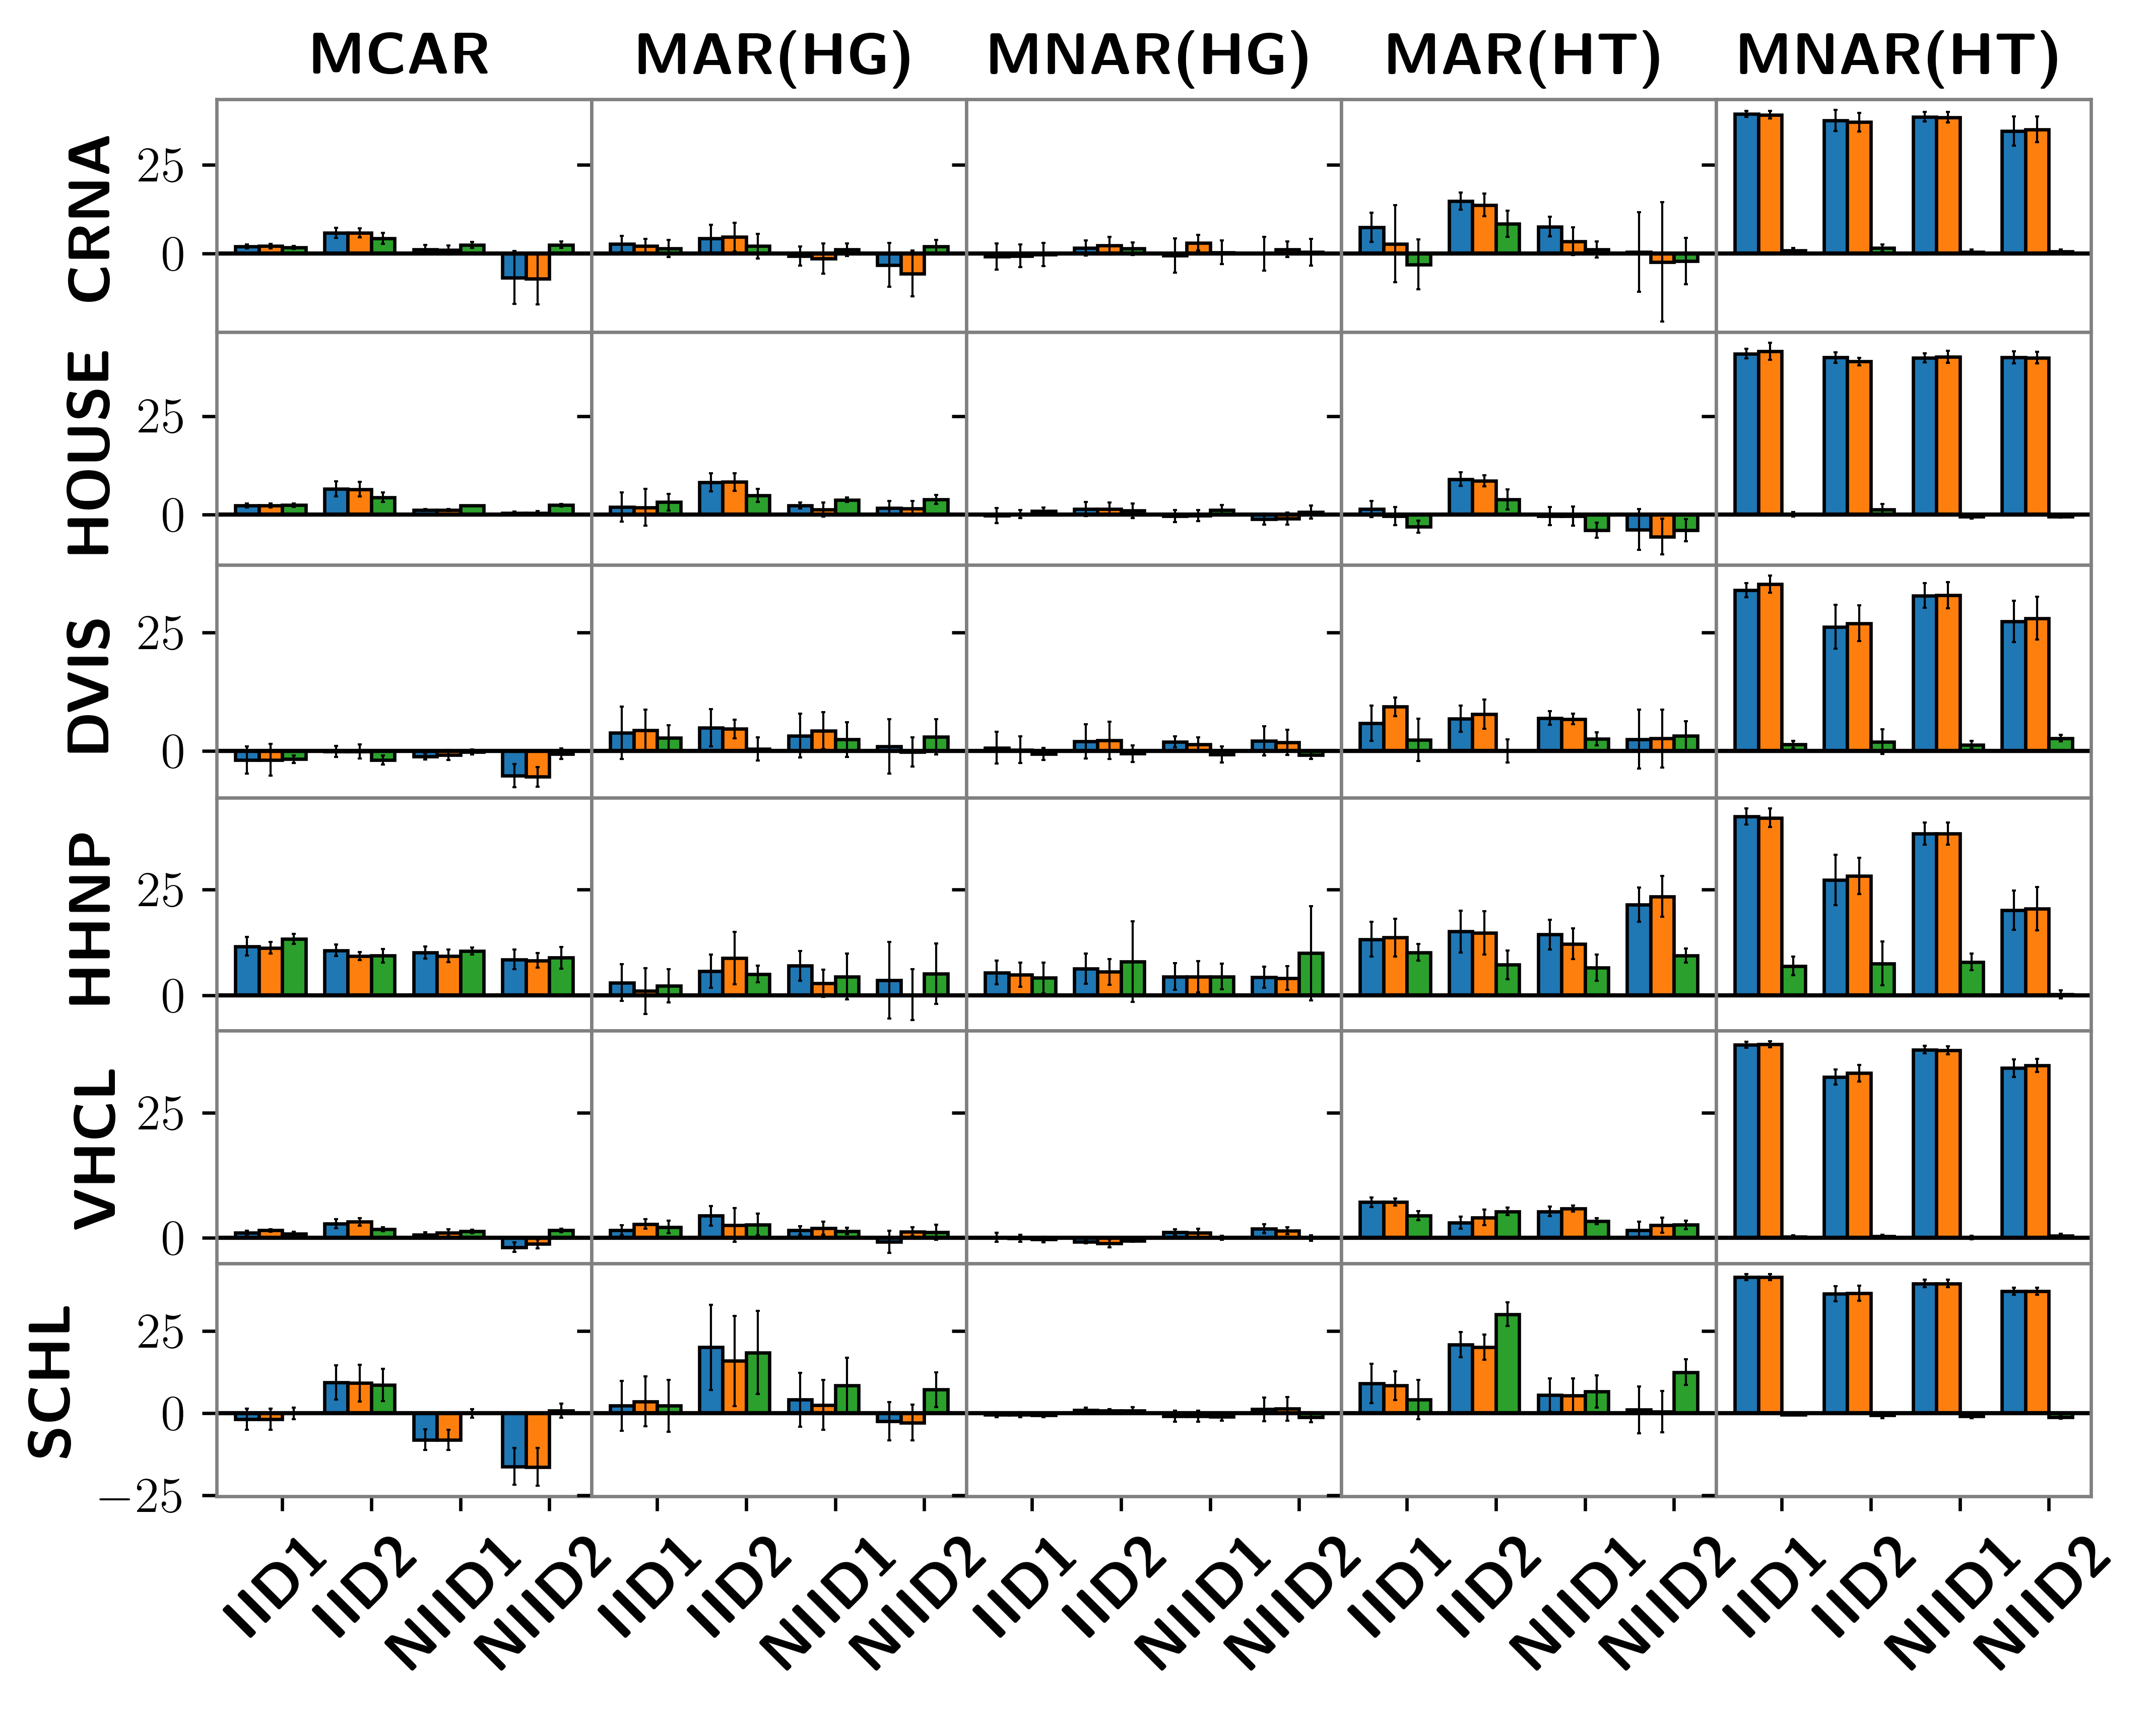

In [126]:
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'figure.dpi': '600'})

bin_width = 1
interval_width = 0.8
lw = 0.8
fontsize = 14
edgecolor = 'black'

def make_bold(s):
    return r'\textbf{' + s + '}'

def bar_plot_imp_improv_nn(df_improv, metric, method, scenarios, datasets, fed, filename = None):
    
    
    fig, axes = plt.subplots(len(datasets), len(scenarios), figsize=(8, 1*len(datasets)), squeeze=False, sharey='row', sharex=True)

    for row_idx, dataset in enumerate(datasets):
        
        partitions = ['iid-even', 'iid-uneven', 'niid1', 'niid2']
        result_avg = df_improv[df_improv['dataset'] == dataset]
        result_avg['imp'] = pd.Categorical(result_avg['imp'], categories=method, ordered=True)
        result_avg[metric] = result_avg[metric]
        
        for col_idx, scenario in enumerate(scenarios):
                
            filtered_df = result_avg[
                (result_avg['missing'] == scenario) & (result_avg['partition'].isin(partitions))
            ]
            
            # plot bars for each partition
            for i in range(len(partitions)):
                # bar_heights for each imp method
                method_fed = [(m, f) for f in fed for m in method]
                partition = partitions[i]
                bar_heights = []
                bar_errors = []
                for j in range(len(method_fed)):
                    d = filtered_df[
                        (filtered_df['fed'] == method_fed[j][1]) & (filtered_df['partition'] == partition) & (
                            filtered_df['imp'] == method_fed[j][0]
                        )
                    ][metric].values
                    bar_heights.append(d.mean())
                    bar_errors.append(d.std())
                
                bar_positions = [i*interval_width + i*len(method_fed)*bin_width + j*bin_width for j in range(len(method_fed))]
                bp = axes[row_idx, col_idx].bar(
                    x = bar_positions, height = bar_heights, width = bin_width, linewidth=[lw]*len(method_fed),
                    ecolor=edgecolor, edgecolor = edgecolor, color = colormaps['tab10'].colors[:len(method_fed)],
                    yerr = bar_errors, error_kw = dict(lw=0.5, capsize=0.5, capthick=0.5)
                    #hatch = [None, None, None, None,  'x', 'x']
                    #color = ['#1e81b0', '#abdbe3', '#7f7f7f', '#d62728'], #hatch = ['\\', 'x', '-',  '/']
                )
            
            # bar labels
            n_groups = len(partitions)
            n_bars = len(method_fed)
            x0 = 0 - bin_width/2 - interval_width
            x1 = (n_groups-1)*interval_width + (n_groups-1)*n_bars*bin_width + (n_bars-1)*bin_width + bin_width/2 + interval_width
            axes[row_idx, col_idx].set_xlim([x0, x1])
            axes[row_idx, col_idx].set_xticks([i*interval_width + i*n_bars*bin_width + 1.5*bin_width for i in range(n_groups)])
            axes[row_idx, col_idx].set_xticklabels(partitions, fontsize = 13)
    
            axes[row_idx, col_idx].set_xticklabels([make_bold(dp_mapping[item]) for item in partitions], fontsize=fontsize, rotation=45) 
            axes[0, col_idx].set_title(make_bold(scenario_mapping[scenario]), fontsize=fontsize)
            axes[row_idx, col_idx].set_xlabel('')
            axes[row_idx, 0].set_ylabel(make_bold(dataset_mapping[dataset]), fontsize=fontsize)
            axes[row_idx, col_idx].tick_params(axis='y', which='major', labelsize=fontsize - 2)
            axes[row_idx, col_idx].spines['bottom'].set_color('grey')
            axes[row_idx, col_idx].spines['top'].set_color('grey')
            axes[row_idx, col_idx].spines['left'].set_color('grey')
            axes[row_idx, col_idx].spines['right'].set_color('grey')
            axes[row_idx, col_idx].avlines = axes[row_idx, col_idx].axhline(y=0, color='black', linewidth=1)
            
            if row_idx == 4 and col_idx == 0:
                axes[row_idx, col_idx].yaxis.set_label_coords(-0.24, 1)


    #plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Imputation Method')
    # legend = plt.legend(
    #     [bp[i] for i in range(len(method_fed))], 
    #     [make_bold(method_fed_mapping[m]) for m in method_fed], 
    #     loc='lower center', bbox_to_anchor=(-1.5, -0.80), 
    #     ncol=3, fontsize = fontsize, frameon=False
    # )
    
    # for text in legend.get_texts():
    #     text.set_fontsize(fontsize-1)
    #     text.set_fontweight('bold')
    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    
    plt.savefig(f"./figures/{filename}", dpi = 600, bbox_inches='tight')
    plt.show()

method = ['miwae']
feds = ['fedavg', 'fedprox', 'fedavg_ft']
scenarios = ['mcar', 'mar-homog', 'mnar2-homog',  'mar-heter', 'mnar2-heter']

df_improv_agg = agg_client_improv2(df_imp_improv, method = 'mean', metric = 'improv', m = 'rmse')
df_improv_agg['fed'] = df_improv_agg['fed'].astype(str)
# df_agg = df_improv_agg.groupby(['dataset', 'partition', 'missing', 'imp', 'fed'], observed = False).agg(
#     {f'sliced-ws_improv': 'mean'}
# ).reset_index()

bar_plot_imp_improv_nn(
    df_improv_agg, 'rmse_improv', method, scenarios, ['codrna', 'california', 'dvisits', 'hhip', 'vehicle', 'school_pca'], fed = feds, 
    filename = 'rmse_improv_miwae.png'
)

## Old Plots

Index(['dataset', 'partition', 'missing', 'imp', 'fed', 'client_id',
       'round_id', 'rmse', 'ws', 'rmse_local', 'ws_local', 'rmse_diff',
       'ws_diff', 'rmse_improv', 'ws_improv'],
      dtype='object')


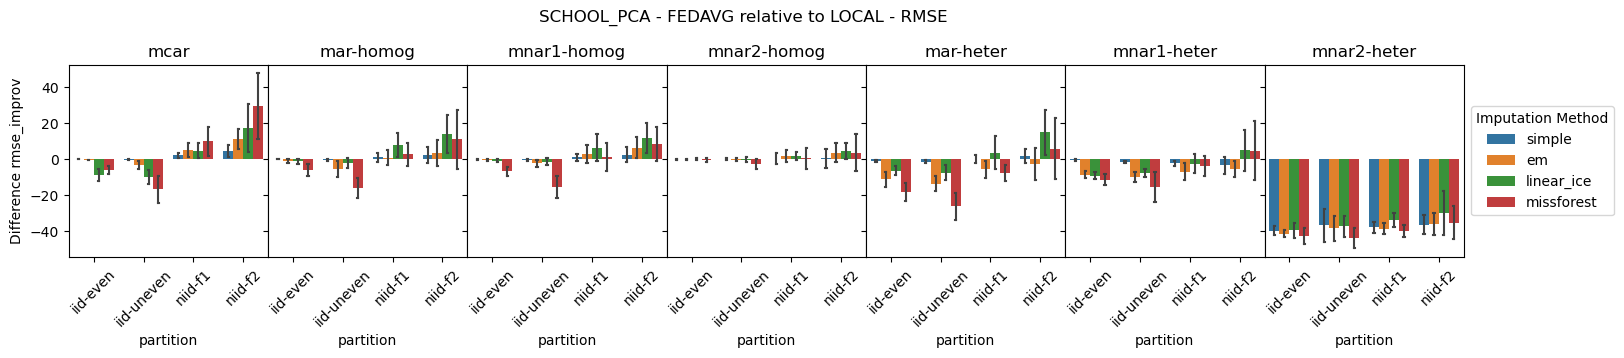

In [164]:
metric = 'ws'
method = ['simple', 'em', 'linear_ice', 'missforest']
scenarios = ['mcar', 'mar-homog', 'mnar1-homog', 'mnar2-homog', 'mar-heter', 'mnar1-heter', 'mnar2-heter']
partitions = ['iid-even', 'iid-uneven', 'niid-f1', 'niid-f2']
dataset = 'school_pca'
bar_plot_new(df_nnn_improv, 'rmse_improv', method, scenarios, partitions, dataset)

Index(['dataset', 'partition', 'missing', 'imp', 'fed', 'client_id',
       'round_id', 'rmse', 'ws', 'rmse_local', 'ws_local', 'rmse_diff',
       'ws_diff', 'rmse_improv', 'ws_improv'],
      dtype='object')


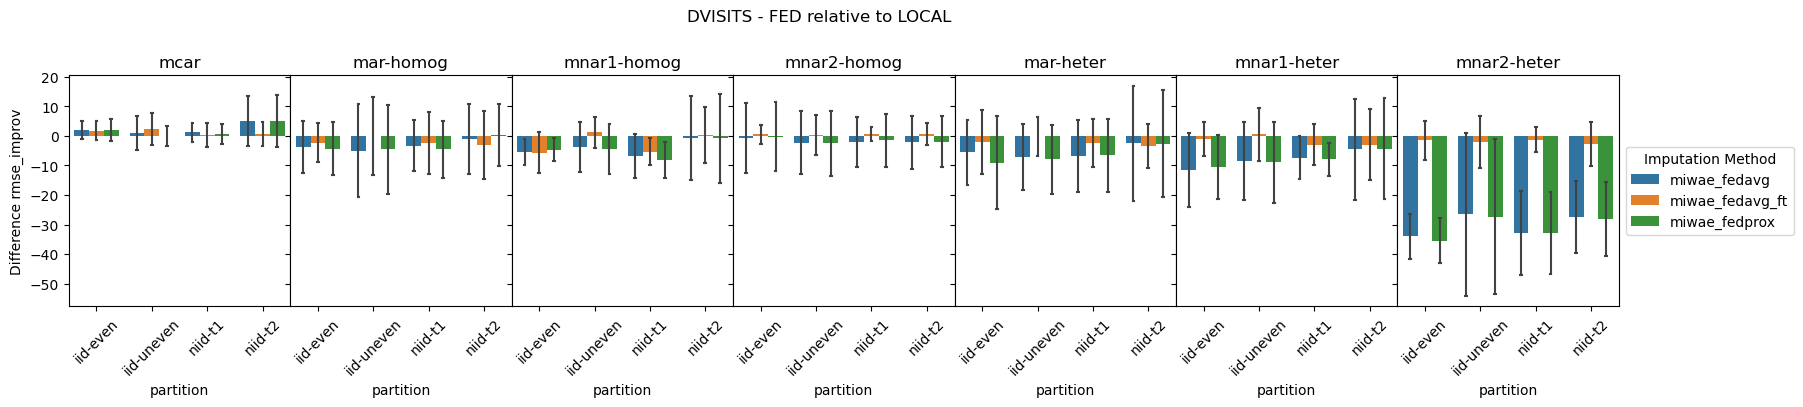

In [142]:
metric = 'ws'
method = ['miwae']
feds = ['fedavg', 'fedavg_ft', 'fedprox']
scenarios = ['mcar', 'mar-homog', 'mnar1-homog', 'mnar2-homog', 'mar-heter', 'mnar1-heter', 'mnar2-heter']
partitions = ['iid-even', 'iid-uneven', 'niid-t1', 'niid-t2']
dataset = 'dvisits'
bar_plot_new_nn(df_nn_improv, 'rmse_improv', method, scenarios, partitions, dataset, feds = feds)

Index(['dataset', 'partition', 'missing', 'imp', 'fed', 'client_id',
       'round_id', 'rmse', 'ws', 'rmse_local', 'ws_local', 'rmse_diff',
       'ws_diff', 'rmse_improv', 'ws_improv'],
      dtype='object')


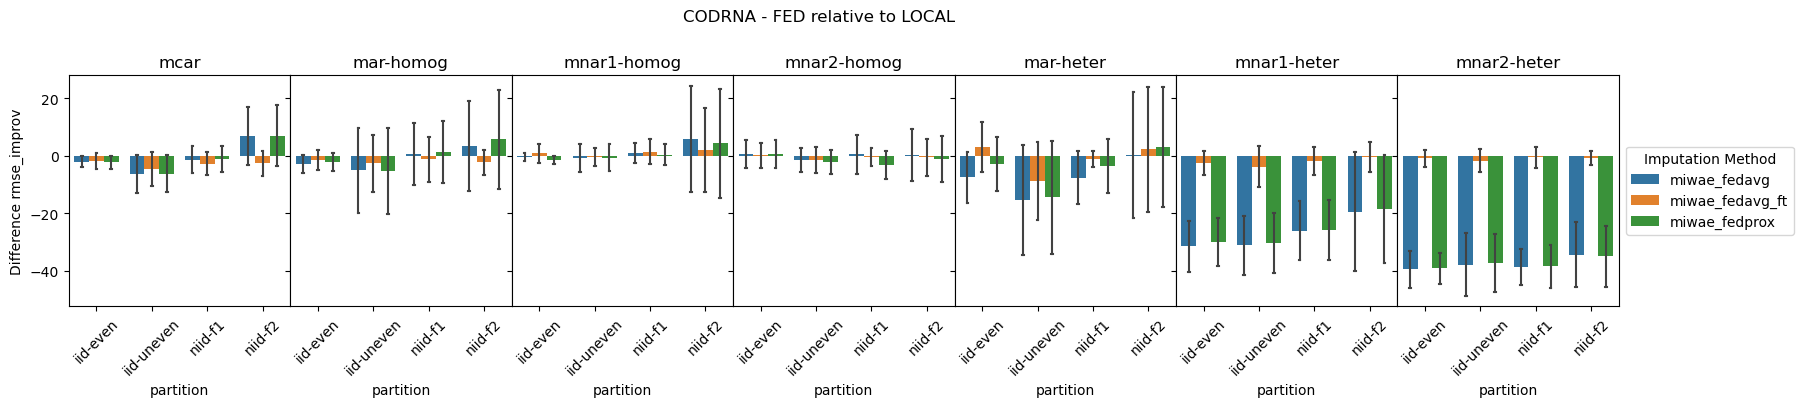

In [56]:
metric = 'ws'
method = ['miwae']
feds = ['fedavg', 'fedavg_ft', 'fedprox']
scenarios = ['mcar', 'mar-homog', 'mnar1-homog', 'mnar2-homog', 'mar-heter', 'mnar1-heter', 'mnar2-heter']
partitions = ['iid-even', 'iid-uneven', 'niid-f1', 'niid-f2']
dataset = 'codrna'
bar_plot_new_nn(df_nn_improv, 'rmse_improv', method, scenarios, partitions, dataset, feds = feds)

Index(['dataset', 'partition', 'missing', 'imp', 'fed', 'client_id',
       'round_id', 'rmse', 'ws', 'rmse_local', 'ws_local', 'rmse_diff',
       'ws_diff', 'rmse_improv', 'ws_improv'],
      dtype='object')


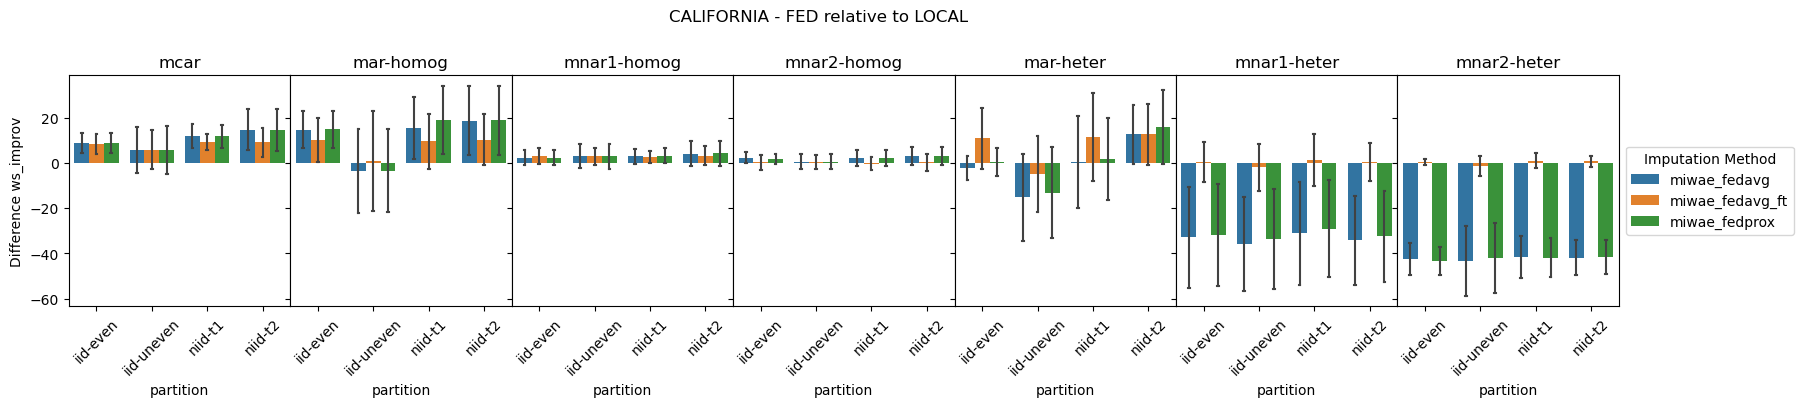

In [134]:
metric = 'ws'
method = ['miwae']
feds = ['fedavg', 'fedavg_ft', 'fedprox']
scenarios = ['mcar', 'mar-homog', 'mnar1-homog', 'mnar2-homog', 'mar-heter', 'mnar1-heter', 'mnar2-heter']
partitions = ['iid-even', 'iid-uneven', 'niid-t1', 'niid-t2']
dataset = 'california'
bar_plot_new_nn(df_nn_improv, 'ws_improv', method, scenarios, partitions, dataset, feds = feds)

Index(['dataset', 'partition', 'missing', 'imp', 'fed', 'client_id',
       'round_id', 'rmse', 'ws', 'rmse_local', 'ws_local', 'rmse_diff',
       'ws_diff', 'rmse_improv', 'ws_improv'],
      dtype='object')


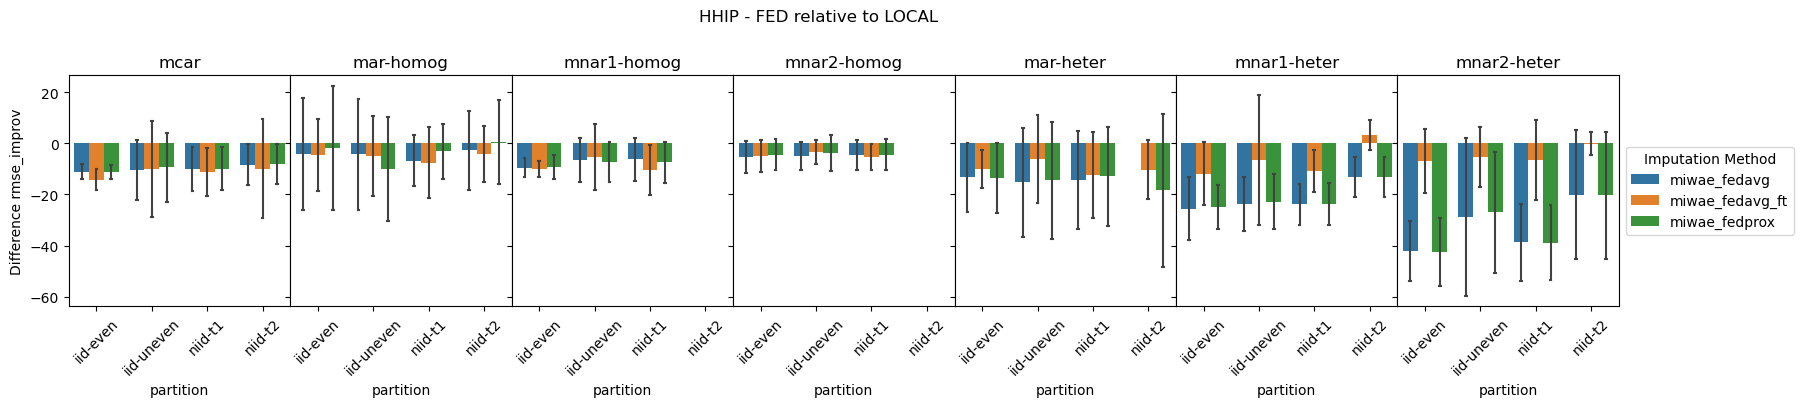

In [63]:
metric = 'ws'
method = ['miwae']
feds = ['fedavg', 'fedavg_ft', 'fedprox']
scenarios = ['mcar', 'mar-homog', 'mnar1-homog', 'mnar2-homog', 'mar-heter', 'mnar1-heter', 'mnar2-heter']
partitions = ['iid-even', 'iid-uneven', 'niid-t1', 'niid-t2']
dataset = 'hhip'
bar_plot_new_nn(df_nn_improv, 'rmse_improv', method, scenarios, partitions, dataset, feds = feds)